## Project name:  Spam or Ham Classifier
### Project author: Kate Nonova

#### Project problem: 
We all face the problem of spams in our inboxes. Spam email is unsolicited and unwanted junk email sent out in bulk to an indiscriminate recipient list. Typically, spam is sent for commercial purposes. It can be sent in massive volume by botnets, networks of infected computers. While some people view it as unethical, many businesses still use spam. The cost per email is incredibly low, and businesses can send out mass quantities consistently. Spam email can also be a malicious attempt to gain access to your computer.

#### Project solution:
The goal here is to identify whether an email is spam or ham. We will take a dataset of labeled email messages and apply classification techniques. We can later test the model for accuracy and performance on unclassified email messages.

#### Paper: 
http://www.ijstr.org/final-print/mar2020/Mobile-Sms-Spam-Filter-Techniques-Using-Machine-Learning-Techniques.pdf

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sea
import string

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import csr_matrix, hstack

### Dataset

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. 

The data is downloadable from Kaggle, https://www.kaggle.com/uciml/sms-spam-collection-dataset

The dataset has 5 572 records. There are 11 fields where "Label" is the target variable - spam or ham.





### Read and analyze the data

Load a dataset from the local file

In [3]:
sms_data = pd.read_csv(r"C:\Kate\AI_Research\Portfolio\SpamClassifier\smsspamcollection\SMSSpamCollection", sep='\t', header=None, names=['Label', 'SMS'])

In [4]:
sms_data.columns = ['label', 'sms']
sms_data.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
sms_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### Distribution Analysis

In [6]:
sms_data["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

The dataset is unbalanced

C:\Users\KateNonova\.conda\envs\tensorflow_gpuenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'No. of ham and spam messages')

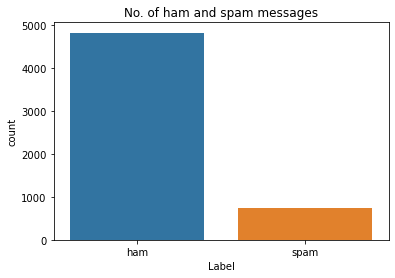

In [7]:
sea.countplot(sms_data.label)
plt.xlabel('Label')
plt.title('No. of ham and spam messages')

Let's look at the length of text to see whether it can predict for spam.

In [8]:
sms_data['sms_length'] = sms_data['sms'].apply(len)

In [9]:
sms_data

,label,sms,sms_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160
5568,ham,Will ü b going to esplanade fr home?,36
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


In [10]:
print('Average sms length: ',sms_data['sms_length'].mean())
print('Average spam sms length: ', sms_data.loc[sms_data['label'] == 'spam']['sms_length'].mean())
print('Average ham sms length: ',  sms_data.loc[sms_data['label'] == 'ham']['sms_length'].mean())

Average sms length:  80.48994974874371
Average spam sms length:  138.6706827309237
Average ham sms length:  71.48248704663213


Text(0.5, 6.79999999999999, 'Length of Text')

<Figure size 720x576 with 0 Axes>

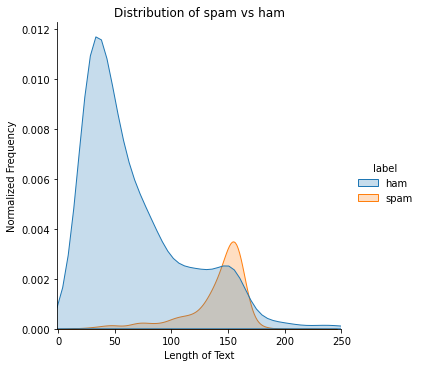

In [11]:
plt.figure(figsize=(10,8))
sea.displot(sms_data, x="sms_length", hue="label", kind="kde", fill=True)
plt.xlim(-1,250)
plt.title('Distribution of spam vs ham')
plt.ylabel('Normalized Frequency')
plt.xlabel('Length of Text')

Text(0.5, 0, 'Length of Text')

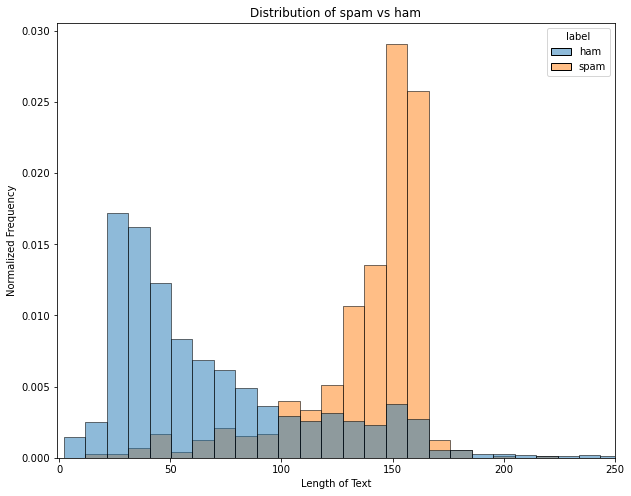

In [12]:
plt.figure(figsize=(10,8))
sea.histplot(data=sms_data, x='sms_length',hue='label',stat="density", common_norm=False)
plt.xlim(-1,250)
plt.title('Distribution of spam vs ham')
plt.ylabel('Normalized Frequency')
plt.xlabel('Length of Text')

Let's see is there any difference between spam message length and ham message lenght

In [13]:
new_df_col = {'label':[], 'sms':[], 'sms_length':[]}
new_sms_data = pd.DataFrame(data=new_df_col)
new_sms_data['sms'] = sms_data['sms'].str.split()
new_sms_data['label'] = sms_data['label']

vocabulary = []
vocabularySpam = []
vocabularyHam = []

for sms in new_sms_data['sms']:
    for word in sms:
        if(word == 'sms'or word =='the' or word == 'this' or word == 'that' or word == 'and'):
            continue
        if(len(word) <= 2):
            continue
        vocabulary.append(word)

# ham
for sms in new_sms_data.loc[new_sms_data['label'] == 'ham']['sms']:
    for word in sms:
        if(word == 'sms'or word =='the' or word == 'this' or word == 'that' or word == 'and'):
            continue
        if(len(word) <= 2):
            continue
        vocabularyHam.append(word)

# spam
for sms in new_sms_data.loc[new_sms_data['label'] == 'spam']['sms']:
    for word in sms:
        if(word == 'sms'or word =='the' or word == 'this' or word == 'that' or word == 'and'):
            continue
        if(len(word) <= 2):
            continue
        vocabularySpam.append(word)

In [14]:
# sms_data.loc[sms_data['label'] == 1]['sms']

In [15]:
full_vocabulary = Counter(vocabulary)
spam_vocabulary = Counter(vocabularySpam)
ham_vocabulary = Counter(vocabularyHam)


In [16]:
print(full_vocabulary.most_common(50))

[('you', 1626), ('for', 650), ('your', 561), ('have', 477), ('are', 397), ('call', 376), ('with', 351), ('not', 344), ('will', 333), ('get', 326), ('can', 304), ("I'm", 286), ('but', 284), ('&lt;#&gt;', 276), ('You', 263), ('from', 256), ('just', 238), ('when', 234), ('like', 224), ('know', 224), ('all', 218), ('out', 207), ('got', 204), ('was', 200), ('come', 199), ('now', 190), ('...', 163), ('want', 158), ('Call', 155), ('time', 154), ('about', 150), ('send', 150), ('only', 147), ('then', 146), ('what', 143), ('going', 142), ('need', 142), ("I'll", 138), ('How', 137), ('still', 135), ('one', 133), ('But', 131), ('its', 129), ('our', 126), ('text', 126), ('been', 121), ('Just', 119), ('there', 118), ('some', 114), ('has', 114)]


In [17]:
print(ham_vocabulary.most_common(100))

[('you', 1462), ('for', 481), ('your', 374), ('have', 349), ('not', 324), ('are', 320), ('will', 294), ('get', 281), ('can', 279), ("I'm", 278), ('but', 277), ('&lt;#&gt;', 276), ('with', 250), ('when', 225), ('like', 211), ('know', 202), ('got', 200), ('come', 198), ('all', 193), ('was', 191), ('call', 191), ('just', 190), ('You', 186), ('out', 167), ('...', 162), ('about', 143), ('want', 142), ('going', 141), ('from', 140), ('then', 138), ("I'll", 138), ('time', 138), ('need', 136), ('How', 132), ('But', 131), ('what', 131), ('still', 129), ('one', 128), ('now', 126), ('its', 125), ('think', 112), ('good', 110), ('there', 109), ('how', 109), ('love', 108), ('some', 108), ("don't", 106), ('home', 106), ('see', 106), ('send', 104), ('only', 102), ('day', 99), ('What', 98), ('And', 98), ('her', 94), ('dont', 94), ('back', 92), ('tell', 91), ("i'm", 91), ('me.', 90), ('Just', 89), ('him', 89), ('take', 88), ('later', 87), ('any', 87), ('she', 85), ('&amp;', 84), ('has', 83), ('give', 83)

In [18]:
print(spam_vocabulary.most_common(100))

[('your', 187), ('call', 185), ('for', 169), ('you', 164), ('Call', 136), ('have', 128), ('from', 116), ('with', 101), ('FREE', 89), ('mobile', 81), ('You', 77), ('are', 77), ('our', 76), ('claim', 73), ('Your', 71), ('txt', 68), ('text', 68), ('now', 64), ('Txt', 63), ('reply', 58), ('free', 56), ('contact', 56), ('now!', 49), ('just', 48), ('send', 46), ('won', 45), ('get', 45), ('only', 45), ('Nokia', 45), ('prize', 44), ('per', 44), ('STOP', 44), ('been', 43), ('service', 43), ('who', 43), ('Reply', 42), ('new', 42), ('cash', 42), ('out', 40), ('Text', 39), ('will', 39), ('This', 39), ('stop', 38), ('awarded', 37), ('Free', 35), ('Please', 34), ('£1000', 33), ('draw', 33), ('URGENT!', 32), ('Get', 32), ('every', 32), ('shows', 31), ('has', 31), ('receive', 30), ('customer', 30), ('Claim', 30), ('week', 30), ('Just', 30), ('win', 28), ('Mobile', 28), ('150ppm', 28), ('number', 28), ('phone', 27), ('latest', 26), ('1st', 26), ('entry', 25), ('selected', 25), ('all', 25), ('guaranteed

In [19]:
vocabulary = list(set(vocabulary))
print(len(vocabulary))

15120


### Clean data: 

Creating a function that will delete all the punctuation in the messages


In [20]:
def remove_punctuation(text):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char

    return no_punct

In [21]:
cleanup_label_nums = {"label": {"ham": 0, "spam":1}} 
sms_data.replace(cleanup_label_nums, inplace=True)

In [22]:
new_df_col = {'label':[], 'sms':[], 'sms_length':[]}

In [23]:
new_sms_data = pd.DataFrame(data=new_df_col)

In [ ]:
for index, row in sms_data.iterrows():
    row.sms = remove_punctuation(row['sms'])
    new_sms_data = new_sms_data.append({'label': int(row.label), 'sms': row.sms, 'sms_length': int(row.sms_length)}, ignore_index=True)


In [ ]:
new_sms_data['sms'] = new_sms_data['sms'].str.lower()
print(new_sms_data)

In [ ]:
sms_spam_data = new_sms_data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Split the data 
Split the data into training and testing set with 80% of the data for training. 


In [ ]:
attributes = sms_spam_data.drop("label", axis = 1)
target = sms_spam_data.label

In [ ]:
sms_attributes_train, sms_attributes_test, sms_target_train, sms_target_test = train_test_split(sms_spam_data['sms'], 
                                                    sms_spam_data['label'], 
                                                    train_size = 0.80,
                                                    random_state=0)

In [ ]:
# Split distribution
print('Train data distribution: ')
print(sms_target_train.value_counts(normalize=True))
print(f'\nTest data distribution: ')
print(sms_target_test.value_counts(normalize=True))

### Model Training

In [ ]:
def add_feature_in_matrix(X, feature_to_add):
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

#### Logistic Regression

In [ ]:
# vectorizer = TfidfVectorizer(min_df=5, ngram_range=[1,3])

# sms_train_transformed = vectorizer.fit_transform(sms_attributes_train)
# sms_train_transformed_with_length = add_feature_in_matrix(sms_train_transformed, [sms_attributes_train.str.len(),
#                                                                     sms_attributes_train.apply(lambda x: len(''.join([a for a in x if a.isdigit()])))])

vectorizer = TfidfVectorizer(min_df=5)

sms_train_transformed = vectorizer.fit_transform(sms_attributes_train)
sms_train_transformed_with_length = add_feature_in_matrix(sms_train_transformed, sms_attributes_train.str.len())


sms_test_transformed = vectorizer.transform(sms_attributes_test)
sms_test_transformed_with_length = add_feature_in_matrix(sms_test_transformed, [sms_attributes_test.str.len()])
#                                                                  sms_attributes_test.apply(lambda x: len(''.join([a for a in x if a.isdigit()])))])

logistic_reg_model = LogisticRegression(C=100)



In [ ]:
logistic_reg_model.fit(sms_train_transformed, sms_target_train)

#### Logistic Regression Model Evaluation



In [ ]:
target_predicted = logistic_reg_model.predict(sms_test_transformed)

In [ ]:
logistic_regression_score = roc_auc_score(sms_target_test, target_predicted)
print('AUC score: ', logistic_regression_score)

In [ ]:
tn, fp, fn, tp = confusion_matrix(sms_target_test, target_predicted).ravel()
print(pd.DataFrame(confusion_matrix(sms_target_test, target_predicted),
             columns=['Predicted Spam', "Predicted Ham"], index=['Actual Spam', 'Actual Ham']))

print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')


print(f'\nTrue Positive Rate: { (tp / (tp + fn))}')
print(f'\nTrue Negative Rate: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')

In [ ]:
plot_confusion_matrix(logistic_reg_model, sms_test_transformed, sms_target_test)  
plt.show()  

In [ ]:
tn, fp, fn, tp = confusion_matrix(sms_target_test, logistic_reg_model.predict(sms_test_transformed)).ravel()
print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

#### Decision Tree Modeling 
 Choosing the best params using grid-search

In [ ]:
dec_tree_params = {
    'max_depth':[None, 0, 10, 100],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
}

dec_tree_grid_search = GridSearchCV(DecisionTreeClassifier(), dec_tree_params, cv=5, verbose=1)

In [ ]:
dec_tree_grid_search.fit(sms_train_transformed_with_length, sms_target_train)

In [ ]:
grid_search_best = dec_tree_grid_search.best_estimator_
print(grid_search_best)

In [ ]:
decision_tree_score = grid_search_best.score(sms_test_transformed_with_length, sms_target_test, sample_weight=None)
print('Score: ', decision_tree_score)

#### Multinomial Naive Bayes Classifier Model Model Training
Let’s first try fitting a classic Multinomial Naive Bayes Classifier Model (MNNB), on X_train and Y_train.

In [ ]:
vect = CountVectorizer().fit(sms_attributes_train)
sms_attributes_train_vectorized = vect.transform(sms_attributes_train)

# vect2 = CountVectorizer().fit(sms_attributes_test)
sms_attributes_test_vectorized = vect.transform(sms_attributes_test)

In [ ]:
naive_bayes_model = MultinomialNB(alpha=0.1)

In [ ]:
model_fit = naive_bayes_model.fit(sms_attributes_train_vectorized, sms_target_train)

#### MNNB Model Evaluation

In [ ]:
predictions = naive_bayes_model.predict(vect.transform(sms_attributes_test))

In [ ]:
naive_bayes_score = roc_auc_score(sms_target_test, predictions) 
print('AUC score: ', naive_bayes_score)

In [ ]:
plot_roc_curve(naive_bayes_model, sms_attributes_test_vectorized, sms_target_test) 
plt.show()

In [ ]:
plot_confusion_matrix(naive_bayes_model, sms_attributes_test_vectorized, sms_target_test)  
plt.show()  

In [ ]:
tn, fp, fn, tp = confusion_matrix(sms_target_test, predictions).ravel()
print(pd.DataFrame(confusion_matrix(sms_target_test, predictions),
             columns=['Predicted Spam', "Predicted Ham"], index=['Actual Spam', 'Actual Ham']))

print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print(f'\nTrue Positive Rate: { (tp / (tp + fn))}')
print(f'True Negative Rate: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')

#### SVC Model Training

In [ ]:
#fit and transfor x_train and X_test
vectorizer = TfidfVectorizer(min_df=5)

sms_train_transformed = vectorizer.fit_transform(sms_attributes_train)
sms_train_transformed_with_length = add_feature_in_matrix(sms_train_transformed, sms_attributes_train.str.len())

In [ ]:
sms_test_transformed = vectorizer.transform(sms_attributes_test)
sms_test_transformed_with_length = add_feature_in_matrix(sms_test_transformed, sms_attributes_test.str.len())

In [ ]:
# SVM creation
svc_model = SVC(C=1000)

svc_model.fit(sms_train_transformed_with_length, sms_target_train)

#### SVC Model Evaluation

In [ ]:
target_predicted = svc_model.predict(sms_test_transformed_with_length)

In [ ]:
svm_score = roc_auc_score(sms_target_test, target_predicted)
print('SVM score: ', svm_score)

In [ ]:
plot_confusion_matrix(svc_model, sms_test_transformed_with_length, sms_target_test)  
plt.show()  

In [ ]:
tn, fp, fn, tp = confusion_matrix(sms_target_test, target_predicted).ravel()
print(pd.DataFrame(confusion_matrix(sms_target_test, target_predicted),
             columns=['Predicted Spam', "Predicted Ham"], index=['Actual Spam', 'Actual Ham']))

print(f'\nTrue Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')


print(f'\nTrue Positive Rate: { (tp / (tp + fn))}')
print(f'True Negative Rate: { (tn / (tn + fp))}')
print(f'False Positive Rate: { (fp / (fp + tn))}')

#### KNN Model Training

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=2)

In [ ]:
knn_grid_params = {
    'n_neighbors': [2,5,10],
    'weights': ['uniform', 'distance'],
    'metric' : ['euclidian', 'manhattan']
}

In [ ]:
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_grid_params, cv=5, verbose=1)

In [ ]:
knn_grid_search.fit(sms_attributes_train_vectorized, sms_target_train)

In [ ]:
knn_grid_search_best = knn_grid_search.best_estimator_
print('best estimator: ', knn_grid_search_best)

In [ ]:
knn_score = knn_grid_search_best.score(sms_attributes_test_vectorized, sms_target_test, sample_weight=None)
print('Score: ', knn_score)

### Model Comparison

In [ ]:
label = ['Logistic', 'MNNB', 'SVC', 'Decision Tree', 'KNN']
score_list = [logistic_regression_score, naive_bayes_score, svm_score, decision_tree_score, knn_score]

def plot_bar_x():
    index = np.arange(len(label))
    clrs = ['grey' if (x < max(score_list)) else 'red' for x in score_list ]
    g=sea.barplot(x=index, y=score_list, palette=clrs) # color=clrs)   
    plt.xlabel('Model type', fontsize=10)
    plt.ylabel('AUC score', fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=30)
    plt.title('AUC score for each fitted model')
    ax=g
    for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                 textcoords='offset points')
    g.set_ylim(0,1.25) 

plot_bar_x()